In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             3222 non-null   float64
 1   bath            3222 non-null   float64
 2   acre_lot        3222 non-null   float64
 3   zip_code        3222 non-null   float64
 4   house_size      3222 non-null   float64
 5   prev_sold_date  3222 non-null   object 
 6   price           3222 non-null   float64
dtypes: float64(6), object(1)
memory usage: 176.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             3222 non-null   float64
 1   bath            3222 non-null   float64
 2   acre_lot        3222 non-null   float64
 3   zip_code        3222 non-null   float64
 4   house_size      3222 non-null   float64
 5   price           3222 non-null   float64
 6   prev_sold_year  3222 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 176.3 KB


In [5]:
outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)

zip_code
8016.0    58
8081.0    55
8046.0    55
8210.0    51
8757.0    48
          ..
7081.0     1
8329.0     1
8327.0     1
8326.0     1
7853.0     1
Name: zip_code, Length: 421, dtype: int64

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([8016])]
#,8081,8046,8210

In [7]:
features = ["bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

In [8]:
X = one_zipcode_df[features]
y = one_zipcode_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [9]:
results_dict = {"model":[],"mae score":[],"mse score":[],"r2 score":[]}

In [10]:
def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [11]:
ridge = Ridge(random_state=42)
ridge_sfs = SequentialFeatureSelector(estimator=ridge, n_features_to_select=num_features_to_select)
ridge_sfm = SelectFromModel(estimator=ridge, threshold=1000)
ridge_rfe = RFE(estimator=ridge, n_features_to_select=num_features_to_select)

In [12]:
ridge_gscv = GridSearchCV(Ridge(random_state=42), {'alpha': np.arange(0.20,0.40,0.01)})
ridge_gscv_model = ridge_gscv.fit(X, y)
print(f"Best parameters found: {ridge_gscv.best_params_}")

Best parameters found: {'alpha': 0.3100000000000001}


In [13]:
ridge = Ridge(**ridge_gscv.best_params_)
ridge_model = ridge.fit(X_train,y_train)
ridge_predict = ridge_model.predict(X_test)
ridge_mse = mean_squared_error(y_test,ridge_predict)
print_more_stuff("Ridge Best Params", y_test, ridge_predict)

Ridge Best Params MSE = 4,850,391,678.454927
Ridge Best Params MAE = 50,824.179681
Ridge Best Params R2 = 0.607191


ridge_predict = ridge_model.predict(X_test)
print_more_stuff("Ridge Regression Test",y_test,ridge_predict)

In [14]:
ridge_sfm_pipeline = Pipeline([
  ('feature_selection', ridge_sfm),
  ('regression', ridge)
])

ridge_sfm_fs = ridge_sfm_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_sfm_get_support = ridge_sfm_fs.get_support()

print('The selected features are:', list(X.columns[ridge_sfm_get_support]))

The selected features are: ['bed', 'bath', 'acre_lot', 'prev_sold_year']


In [15]:
ridge_sfm_model = ridge_sfm_pipeline.fit(X_train,y_train)
ridge_sfm_predict = ridge_sfm_model.predict(X_test)
print_more_stuff("SelectFromModel",y_test,ridge_sfm_predict)

SelectFromModel MSE = 4,983,129,117.182839
SelectFromModel MAE = 51,477.068193
SelectFromModel R2 = 0.596442


In [16]:
ridge_sfs_pipeline = Pipeline([
  ('feature_selection', ridge_sfs),
  ('regression', ridge)
])

ridge_sfs_fs = ridge_sfs_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_sfs_get_support = ridge_sfs_fs.get_support()

print('The selected features are:', list(X.columns[ridge_sfs_get_support]))

The selected features are: ['bed', 'bath', 'acre_lot', 'house_size']


In [17]:
ridge_sfs_model = ridge_sfs_pipeline.fit(X_train,y_train)
ridge_sfs_predict = ridge_sfs_model.predict(X_test)
print_more_stuff("SequentialFeatureSelector",y_test,ridge_sfs_predict)

SequentialFeatureSelector MSE = 4,634,184,832.144733
SequentialFeatureSelector MAE = 49,475.628451
SequentialFeatureSelector R2 = 0.624701


In [18]:
ridge_rfe_pipeline = Pipeline([
  ('feature_selection', ridge_rfe),
  ('regression', ridge)
])
ridge_rfe_fs = ridge_rfe_pipeline.named_steps['feature_selection'].fit(X_train,y_train)
ridge_rfe_get_support = ridge_rfe_fs.get_support()

print('The selected features are:', list(X.columns[ridge_rfe_get_support]))

The selected features are: ['bed', 'bath', 'acre_lot', 'prev_sold_year']


In [19]:
ridge_rfe_model = ridge_rfe_pipeline.fit(X_train,y_train)
ridge_rfe_predict = ridge_rfe_model.predict(X_test)
print_more_stuff("Recursive Feature Elimination",y_test,ridge_rfe_predict)

Recursive Feature Elimination MSE = 4,983,129,117.182839
Recursive Feature Elimination MAE = 51,477.068193
Recursive Feature Elimination R2 = 0.596442


In [20]:
ridge_predict_df = pd.DataFrame(ridge_predict).reset_index()
ridge_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfm_predict_df = pd.DataFrame(ridge_sfm_predict).reset_index()
ridge_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_sfs_predict_df = pd.DataFrame(ridge_sfs_predict).reset_index()
ridge_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

ridge_rfe_predict_df = pd.DataFrame(ridge_rfe_predict).reset_index()
ridge_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

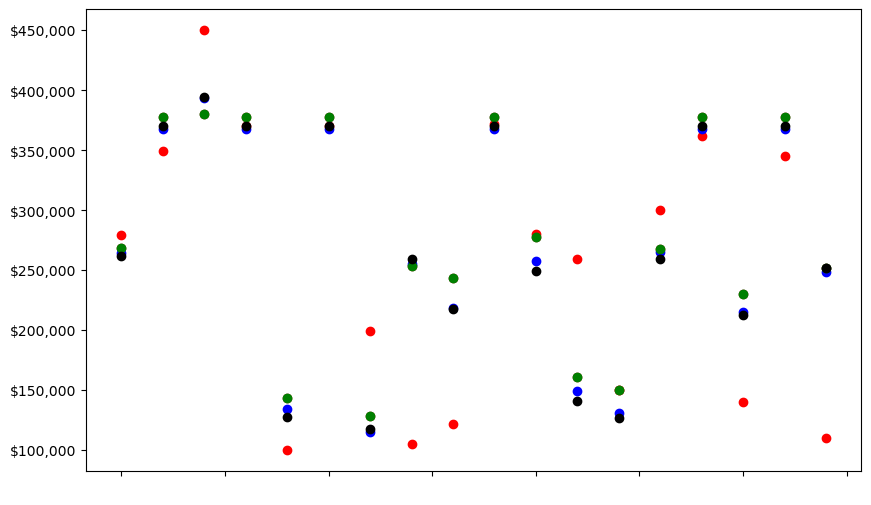

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="brown")
plt.scatter(ridge_sfs_predict_df.index,ridge_sfs_predict_df["prediction"], color="blue")
plt.scatter(ridge_rfe_predict_df.index,ridge_rfe_predict_df["prediction"], color="green")
plt.scatter(ridge_predict_df.index,ridge_predict_df["prediction"], color="black")
plt.show()

In [22]:
ridge_predict_df.sort_values(by='prediction', inplace=True)
ridge_predict_df.reset_index(inplace=True)

ridge_sfm_predict_df.sort_values(by='prediction', inplace=True)
ridge_sfm_predict_df.reset_index(inplace=True)

ridge_sfs_predict_df.sort_values(by='prediction', inplace=True)
ridge_sfs_predict_df.reset_index(inplace=True)

ridge_rfe_predict_df.sort_values(by='prediction', inplace=True)
ridge_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

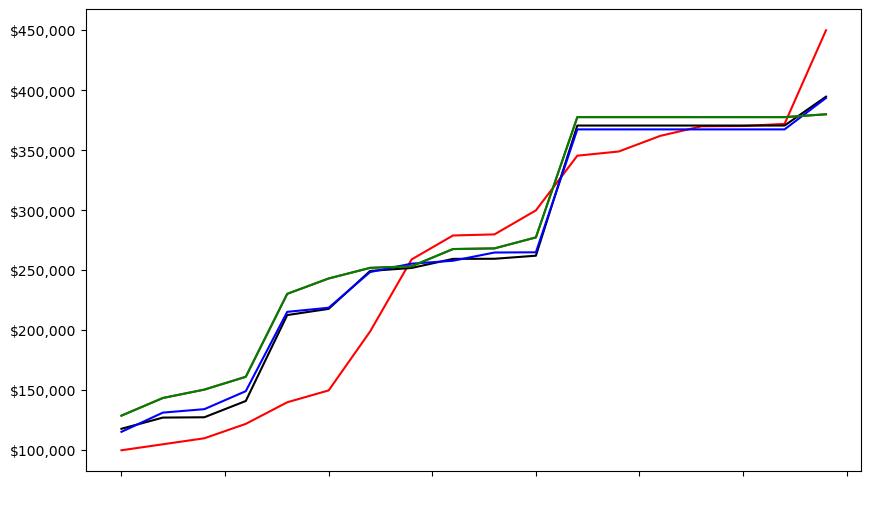

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(ridge_predict_df.index,ridge_predict_df["prediction"], color="black")
plt.plot(ridge_sfm_predict_df.index,ridge_sfm_predict_df["prediction"], color="brown")
plt.plot(ridge_sfs_predict_df.index,ridge_sfs_predict_df["prediction"], color="blue")
plt.plot(ridge_rfe_predict_df.index,ridge_rfe_predict_df["prediction"], color="green")
plt.show()

In [24]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,mae score,mse score,r2 score
model,,,
Ridge Best Params,"50,824.179681","4,850,391,678.454927",0.607191
SelectFromModel,"51,477.068193","4,983,129,117.182839",0.596442
SequentialFeatureSelector,"49,475.628451","4,634,184,832.144733",0.624701
Recursive Feature Elimination,"51,477.068193","4,983,129,117.182839",0.596442
